In [1]:
from MPC import *
from WindGym import WindFarmEnv
from utils import make_config

/home/marcus/miniconda3/envs/testenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
USE_VARIABLE_HORIZON = True   # Use variable prediction horizon (paper's approach)
USE_TIME_SHIFTED = True      # Use time-shifted cost function (paper's best)
APPLY_YAW_PENALTY = True      # Use Equation 5 penalty for large yaw angles


In [3]:
config = make_config()

env = WindFarmEnv(
    turbine=V80(),  # e.g., IEA37/DTU10MW WT from PyWake
    x_pos=np.array([0, 400, 800]),  # x positions of the turbines
    y_pos=np.array([0, 0, 0]),      # y positions of the turbines
    config=config,
    turbtype="None",
    dt_env=60,
    dt_sim=10,
    yaw_step_sim=10*0.3,  # 10 sim step * 0.3 (yaw actuation time)
    yaw_init='Zeros',
    n_passthrough=30,
    reset_init=0,
    # wd_function=wd_func,
    # backend="pywake",         # <<< switch here
)

obs, info = env.reset(seed=42)

Steady state steps: 6.0


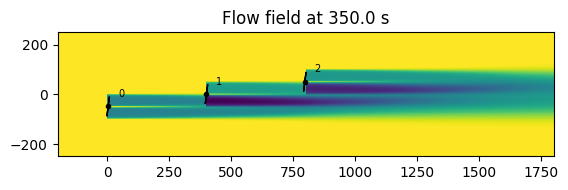

In [4]:
# Plot the inital farm here:
env.plot_farm()

In [5]:
env.wd, env.ws, env.ti, env.current_yaw

(277.1719583982277, 9.547912097111926, 0.05, array([0., 0., 0.]))

In [21]:


obs, info = env.reset(seed=42)

# Setup the MPC
D = env.D
x_pos = env.x_pos.copy()
y_pos = env.y_pos.copy()

mpc_model = WindFarmModel(x_pos, y_pos, D=D, cache_size=64000, 
                            cache_quant=0.25, wind_quant=0.25,
                            apply_yaw_penalty=APPLY_YAW_PENALTY)

current_yaws_orig = env.current_yaw.copy()
history = []

powers_plot = []
yaws_plot = []
time_plot = []

for _ in range(10):

    # Step 1: update the MPC model with the current state
    previous_opt_params = None
    estimated_wd = env.wd
    estimated_ws = env.ws
    estimated_TI = env.ti

    mpc_model.update_conditions(U_inf=estimated_ws, TI=estimated_TI, wd=estimated_wd)

    current_yaws_sorted = current_yaws_orig[mpc_model.sorted_indices]

    # Step 2: optimize the yaw angles

    optimized_params = optimize_farm_back2front(
        mpc_model, current_yaws_sorted, 
        r_gamma=0.3, # yaw rate (deg/s)
        t_AH=100.0,  # action horizon (s)
        dt_opt=10.0,  # optimization time step (s)
        T_opt=500.0,  # prediction horizon (s)
        maxfun=50,
        seed=42,
        initial_params=previous_opt_params
    )

    previous_opt_params = optimized_params.copy()

    dt_mpc = 60 # MPC control interval (s)
    t_action, trajectories, _ = run_farm_delay_loop_optimized(
        mpc_model, optimized_params, current_yaws_sorted, 
        r_gamma=0.3, t_AH=100.0, dt=dt_mpc, T=dt_mpc
    )

    next_yaws_sorted = np.array([traj[-1] for traj in trajectories])
    next_yaws_orig = next_yaws_sorted[mpc_model.unsorted_indices]

    print("next_yaws_orig: ", next_yaws_orig)

    # The action should then be:
    action = (next_yaws_orig - env.yaw_min) / (env.yaw_max - env.yaw_min) * 2 - 1


    # Do the env step:
    obs, reward, terminated, truncated,  info = env.step(action)

    # log for the plot
    powers_plot.append(info["powers"].sum(axis=1))
    time_plot.append(info["time_array"])
    yaws_plot.append(info["yaws"])


Steady state steps: 6.0
next_yaws_orig:  [12.16538876 11.48640901  0.        ]
next_yaws_orig:  [12.16538876 11.48640901  0.        ]
next_yaws_orig:  [12.16538876 11.48640901  0.        ]
next_yaws_orig:  [12.16538876 11.48640901  0.        ]
next_yaws_orig:  [12.16538876 11.48640901  0.        ]
next_yaws_orig:  [12.16538876 11.48640901  0.        ]
next_yaws_orig:  [12.16538876 11.48640901  0.        ]
next_yaws_orig:  [12.16538876 11.48640901  0.        ]
next_yaws_orig:  [12.16538876 11.48640901  0.        ]
next_yaws_orig:  [12.16538876 11.48640901  0.        ]


{'ACADOS_SOURCE_DIR': '/home/marcus/Documents/leap-c/external/acados',
 'CHROME_DESKTOP': 'code.desktop',
 'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/run/user/1000/bus',
 'DEBUGINFOD_URLS': 'https://debuginfod.ubuntu.com ',
 'DESKTOP_SESSION': 'ubuntu',
 'DISPLAY': ':0',
 'GDK_BACKEND': 'x11',
 'GDMSESSION': 'ubuntu',
 'GNOME_DESKTOP_SESSION_ID': 'this-is-deprecated',
 'GNOME_SETUP_DISPLAY': ':1',
 'GNOME_SHELL_SESSION_MODE': 'ubuntu',
 'GSM_SKIP_SSH_AGENT_WORKAROUND': 'true',
 'GTK_MODULES': 'gail:atk-bridge',
 'HOME': '/home/marcus',
 'IM_CONFIG_CHECK_ENV': '1',
 'IM_CONFIG_PHASE': '1',
 'INVOCATION_ID': '8dafb8d368a344a68b781ccc8f3e49b7',
 'JOURNAL_STREAM': '9:1046737',
 'LANG': 'en_US.UTF-8',
 'LD_LIBRARY_PATH': '/home/marcus/miniconda3/envs/testenv/lib:/home/marcus/Documents/leap-c/external/acados/lib:',
 'LESSCLOSE': '/usr/bin/lesspipe %s %s',
 'LESSOPEN': '| /usr/bin/lesspipe %s',
 'LOGNAME': 'marcus',
 'MANAGERPID': '3119',
 'MEMORY_PRESSURE_WATCH': '/sys/fs/cgroup/user.slice/user

In [32]:
time_plot = np.concatenate(time_plot)
powers_plot = np.concatenate(powers_plot)
yaws_plot = np.concatenate(yaws_plot)

In [44]:
env.ws_scaling_max

30.0

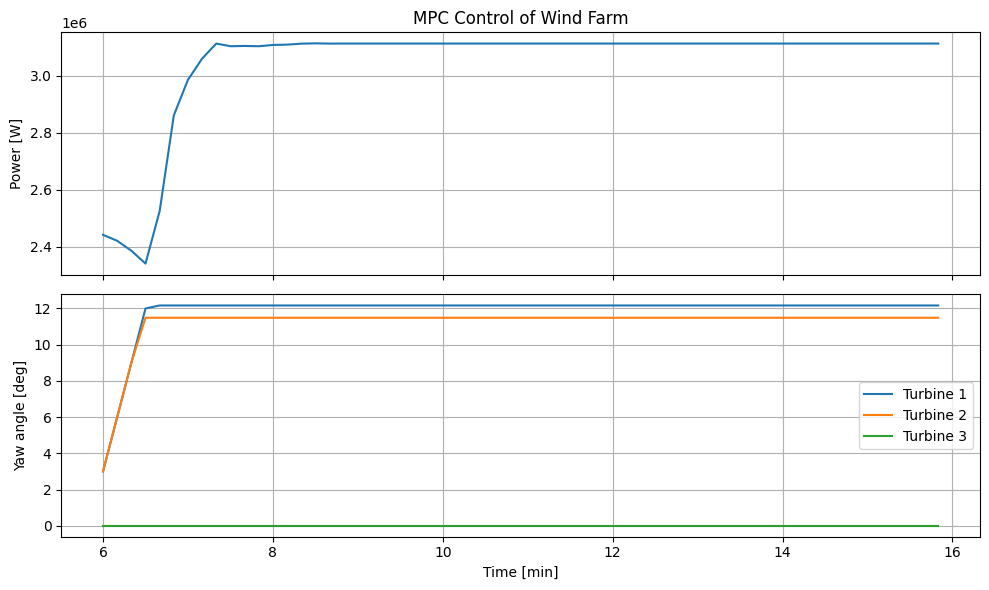

In [38]:
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)

ax[0].plot(time_plot/60, powers_plot)
ax[0].set_ylabel("Power [W]")
ax[0].set_title("MPC Control of Wind Farm")
ax[0].grid()

ax[1].plot(time_plot/60, yaws_plot)
ax[1].set_ylabel("Yaw angle [deg]")
ax[1].set_xlabel("Time [min]")
ax[1].legend([f"Turbine {i+1}" for i in range(yaws_plot.shape[1])])
ax[1].grid()
plt.tight_layout()
plt.show()


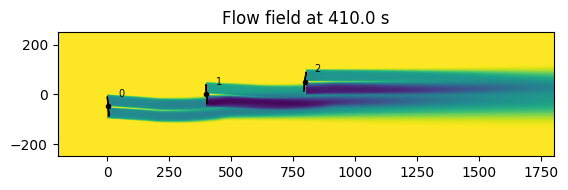

In [22]:
# The farm is now:
env.plot_farm()